<H2>Introduction</H2>

This notebook will answer within it the questions posed as part of the PMIM402 clustering assessment task. This will 
enable users to view code and output alongside further information about the process, which should provide a degree 
of contextual background that will aid users' comprehension of the larger task at hand. Specifically, the questions posed are the following:

**For each classifier, please answer the following:**  
1. Did you undertake any prepossessing? If so, why?  
2. Run the classifier with default parameters.  
    a. How accurately can the classifier predict those that develop heart disease? What is in the output that signifies this?  
    b. How many people are misclassified as developing heart disease? Where is this answer found in the output?
3. Plot and submit ROC curves for the class that develops heart disease. What is 
another measure of accuracy commonly used? 

**Now choose one classifier to further optimize.** 
1. Why did you choose this classifier over the other?
2. Explain how this classifier works from a theoretical point of view.
3. Try to optimize the classifier to achieve a higher accuracy (no matter how small) than first found. Remember that we have a particular focus on predicting those that develop heart disease.  
    a. Were there any features that could be removed? How you could you determine this using Weka? Please print the output that helped you make this decision.  
    b. Did changing the way data is sampled during training/testing affect the accuracy?  
    c. What about some of the internal parameters specific to the classifier? Please explain how one of these parameters can affect accuracy.
4. In general, a classifier is only as good as the data it is trained on. Please comment on what is needed from training data to train a good classifier. How can utilizing classifiers help feed back into healthcare settings with regards to data collection?     




These questions will be answered at appropriate points during this notebook. This may mean that they are not necessarily answered in the order specified above, but this is to ensure that they are answered in the context of both code and output that will help to demonstrate the responses in practical terms.  
  
<H2>Data Preparation and Pre-Processing</H2>

The first thing that we need to do is to load in the libraries that we will need for the rest of the notebook. In addition to this, we will also make some tweaks to make our plots more legibile. We will also undertake some exploratory data analysis to ascertain if there are any changes that we need to make to the data to get it in to a better format for our classification tasks.

In [94]:
# Necessary libraries
library(tidyverse)
library(factoextra)
library(dendextend)
library(cluster)
library(clValid)
library(cowplot)
library(hardhat)
library(mice)

# Make plots more appropriately sized
options(repr.plot.width=15, repr.plot.height=8)

# Enable viewing of all columns in a data set
options(repr.matrix.max.cols=30)

set.seed(42)


In [95]:
# Read in data and put in to data frame. 
heart <- read.csv("heart_disease_modified.csv", stringsAsFactors = TRUE)[-1] %>% as.data.frame 

# View the dimensions of our data frame
dim(heart)


[1] 920  21

We can see above that this data frame contains 920 rows (observations) and 21 features (columns). We have also converted any string values to factors, as this will support better data exploration and optimise the data for machine learning. Converting strings to factors means that, though our data frame shows character (string) values, these are actually represented as integers 'under the hood', as it were. Below we will output the first 15 rows of our data so as we may better understand the features and values within our data.

In [96]:
# View the data
head(heart, 1)


,Patient_ID,sex,age,pace_maker,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,perfusion,slope,ca,thal,smoker,drug,traponin,fam_hist,class
,<int>,<int>,<int>,<fct>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<fct>,<dbl>,<fct>,<int>
1,6698,1,67,NO,4,160,286,0,2,108,1,1.5,0.4775729,2,3,3,1,Aspirin,-47.75729,no,1


The first column above is the _Patient_ID_ column. This column does not provide us with any further insights in to the data. It is likely simply a unique identfier for each particular patient when they were entered in to a database. As we will be conducting machine learning on the data set, this information is of little use as our primary concern is to use the attributes of the observation to build a model to classify new incoming data. For this reason we will remove this ID from our data.  
  
We will also print the levels of our factors. It is important to note that our factors contain no inherent order as they relate to categorical information.

In [97]:
# Make the predictor feature a factor
heart$class <- as.factor(heart$class)

# Remove Patient ID from the data frame
heart <- heart %>% select(-Patient_ID)
head(heart)

# View factor levels
str(heart)

,sex,age,pace_maker,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,perfusion,slope,ca,thal,smoker,drug,traponin,fam_hist,class
,<int>,<int>,<fct>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<fct>,<dbl>,<fct>,<fct>
1,1,67,NO,4,160,286,0,2,108,1,1.5,0.47757292,2,3,3,1,Aspirin,-47.757292,no,1
2,1,67,NO,4,120,229,0,2,129,1,2.6,0.78092841,2,2,7,0,Clopidogrel,-78.092841,no,1
3,0,62,NO,4,140,268,0,2,160,0,3.6,0.60812954,3,2,3,0,None,-60.812954,yes,1
4,1,63,NO,4,130,254,0,2,147,0,1.4,0.17683587,2,1,7,1,Aspirin,-17.683587,no,1
5,1,53,NO,4,140,203,1,2,155,1,3.1,-0.08584768,3,0,7,1,Both,8.584768,yes,1
6,1,56,NO,3,130,256,1,2,142,1,0.6,0.28405195,2,1,6,1,Both,-28.405195,no,1


'data.frame':	920 obs. of  20 variables:
 $ sex       : int  1 1 0 1 1 1 1 1 1 1 ...
 $ age       : int  67 67 62 63 53 56 48 58 58 60 ...
 $ pace_maker: Factor w/ 1 level "NO": 1 1 1 1 1 1 1 1 1 1 ...
 $ cp        : int  4 4 4 4 4 3 2 2 3 4 ...
 $ trestbps  : int  160 120 140 130 140 130 110 120 132 130 ...
 $ chol      : int  286 229 268 254 203 256 229 284 224 206 ...
 $ fbs       : int  0 0 0 0 1 1 0 0 0 0 ...
 $ restecg   : int  2 2 2 2 2 2 0 2 2 2 ...
 $ thalach   : int  108 129 160 147 155 142 168 160 173 132 ...
 $ exang     : int  1 1 0 0 1 1 0 0 0 1 ...
 $ oldpeak   : num  1.5 2.6 3.6 1.4 3.1 0.6 1 1.8 3.2 2.4 ...
 $ perfusion : num  0.4776 0.7809 0.6081 0.1768 -0.0858 ...
 $ slope     : int  2 2 3 2 3 2 3 2 1 2 ...
 $ ca        : int  3 2 2 1 0 1 0 0 2 2 ...
 $ thal      : int  3 7 3 7 7 6 7 3 7 7 ...
 $ smoker    : int  1 0 0 1 1 1 0 0 1 1 ...
 $ drug      : Factor w/ 4 levels "Aspirin","Both",..: 1 3 4 1 2 2 2 4 3 2 ...
 $ traponin  : num  -47.76 -78.09 -60.81 -17.68 8.58 

We can also see above that some of the feature names are rather ambiguous at first glance. Therefore, it would make sense to rename these so as we have better descriptors of our data.

In [98]:
# Create a vector of more meaningful feature names, to enable better comprehension of results.
feature_names = c('sex', 'age', 'pace_maker', 'chest_pain_type','resting_blood_pressure', 
                  'cholesterol','fasting_blood_sugar','resting_ecg', 
                  'max_heart_rate', 'exercise_angina','relative_ST_depression','perfusion', 
                  'peak_ST_slope', 'fluoroscopy_test_result','thallium_test_result', 'smoker', 'drug_taken',
                  'troponin_level', 'family_history', 'class')


# Replace the existing column names with these values
colnames(heart) <- feature_names
head(heart)


,sex,age,pace_maker,chest_pain_type,resting_blood_pressure,cholesterol,fasting_blood_sugar,resting_ecg,max_heart_rate,exercise_angina,relative_ST_depression,perfusion,peak_ST_slope,fluoroscopy_test_result,thallium_test_result,smoker,drug_taken,troponin_level,family_history,class
,<int>,<int>,<fct>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<fct>,<dbl>,<fct>,<fct>
1,1,67,NO,4,160,286,0,2,108,1,1.5,0.47757292,2,3,3,1,Aspirin,-47.757292,no,1
2,1,67,NO,4,120,229,0,2,129,1,2.6,0.78092841,2,2,7,0,Clopidogrel,-78.092841,no,1
3,0,62,NO,4,140,268,0,2,160,0,3.6,0.60812954,3,2,3,0,None,-60.812954,yes,1
4,1,63,NO,4,130,254,0,2,147,0,1.4,0.17683587,2,1,7,1,Aspirin,-17.683587,no,1
5,1,53,NO,4,140,203,1,2,155,1,3.1,-0.08584768,3,0,7,1,Both,8.584768,yes,1
6,1,56,NO,3,130,256,1,2,142,1,0.6,0.28405195,2,1,6,1,Both,-28.405195,no,1


In [100]:
# Convert all categorical data to factors

cols <- c('sex', 'chest_pain_type', 'fasting_blood_sugar','resting_ecg', 'exercise_angina',
          'peak_ST_slope', 'fluoroscopy_test_result','thallium_test_result', 'smoker')

heart[cols] <- lapply(heart[cols], factor) 

head(heart)

,sex,age,pace_maker,chest_pain_type,resting_blood_pressure,cholesterol,fasting_blood_sugar,resting_ecg,max_heart_rate,exercise_angina,relative_ST_depression,perfusion,peak_ST_slope,fluoroscopy_test_result,thallium_test_result,smoker,drug_taken,troponin_level,family_history,class
,<fct>,<int>,<fct>,<fct>,<int>,<int>,<fct>,<fct>,<int>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<fct>,<fct>
1,1,67,NO,4,160,286,0,2,108,1,1.5,0.47757292,2,3,3,1,Aspirin,-47.757292,no,1
2,1,67,NO,4,120,229,0,2,129,1,2.6,0.78092841,2,2,7,0,Clopidogrel,-78.092841,no,1
3,0,62,NO,4,140,268,0,2,160,0,3.6,0.60812954,3,2,3,0,None,-60.812954,yes,1
4,1,63,NO,4,130,254,0,2,147,0,1.4,0.17683587,2,1,7,1,Aspirin,-17.683587,no,1
5,1,53,NO,4,140,203,1,2,155,1,3.1,-0.08584768,3,0,7,1,Both,8.584768,yes,1
6,1,56,NO,3,130,256,1,2,142,1,0.6,0.28405195,2,1,6,1,Both,-28.405195,no,1


In [101]:
# Check for NA values
colSums(is.na(heart))


sex                     age              pace_maker 
                      0                       0                       0 
        chest_pain_type  resting_blood_pressure             cholesterol 
                      0                       0                       0 
    fasting_blood_sugar             resting_ecg          max_heart_rate 
                      0                       0                       0 
        exercise_angina  relative_ST_depression               perfusion 
                      0                       0                       0 
          peak_ST_slope fluoroscopy_test_result    thallium_test_result 
                      0                       0                       0 
                 smoker              drug_taken          troponin_level 
                      0                       0                       0 
         family_history                   class 
                      0                       0

We can see that this data has no missing values - however this does not necessarily mean that the data is clean and in good shape to be used with our machine learning model. Next we will plot all of the continuous data to see if there are any issues that might become apparent based upon the distrubution of the data.

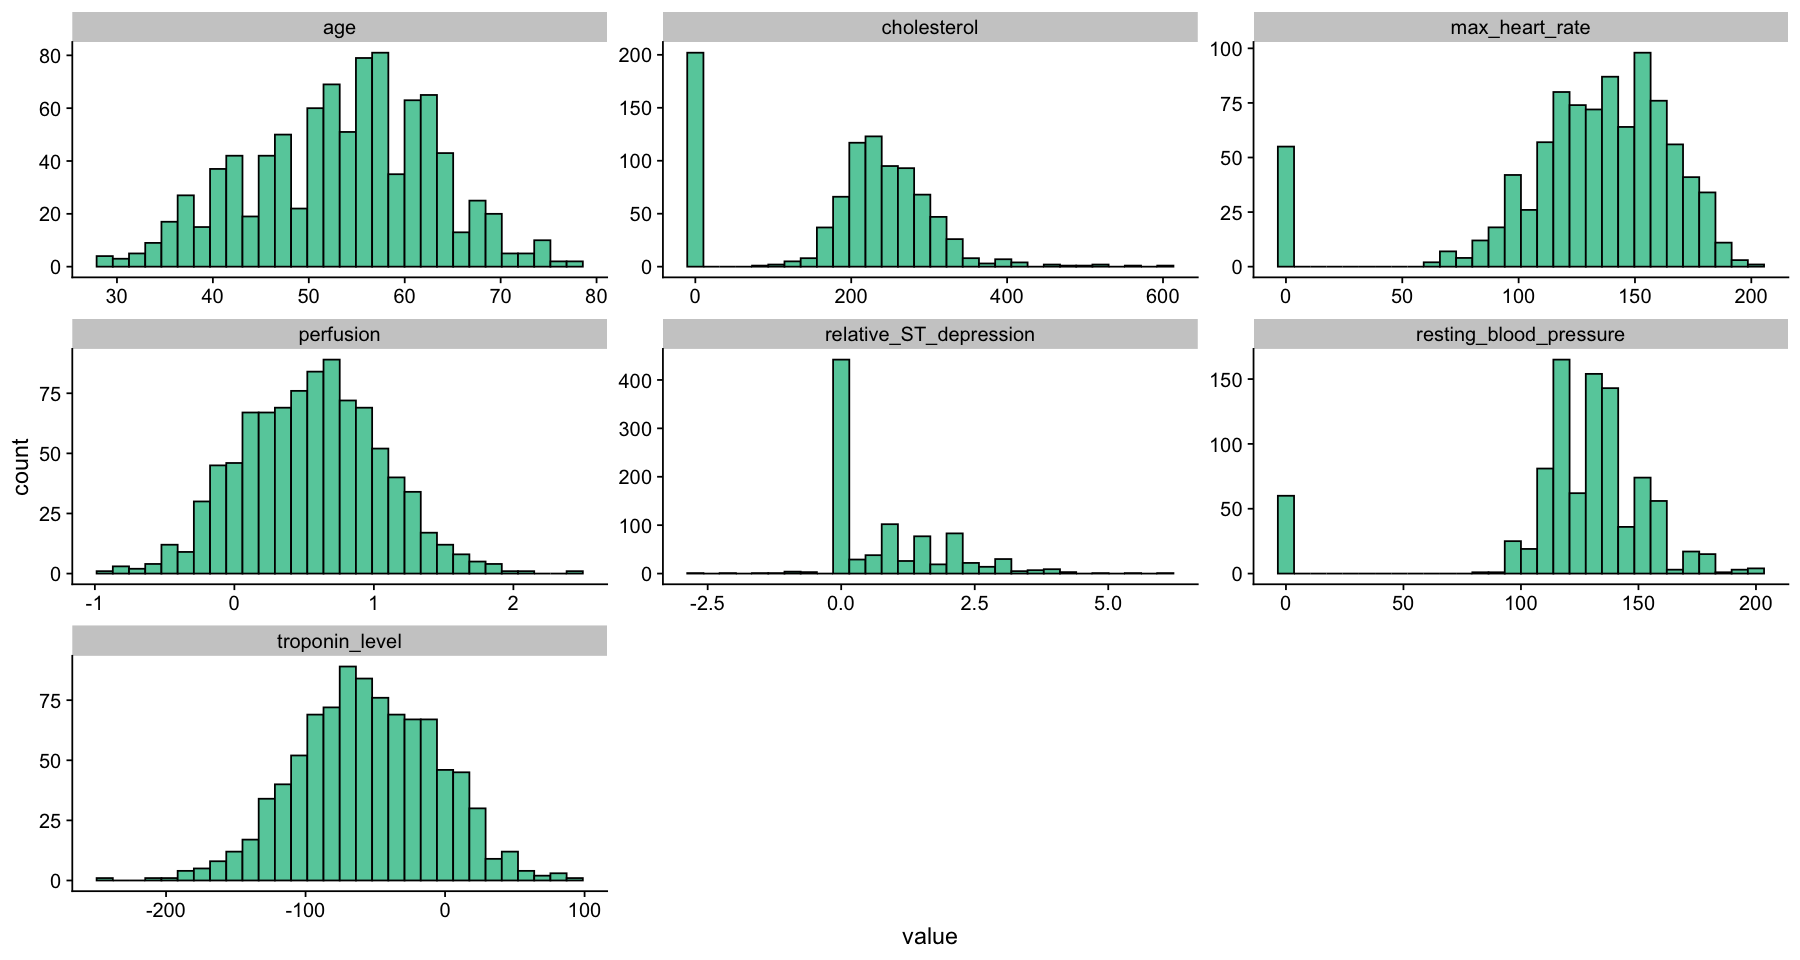

In [102]:
heart_cont <- heart %>% select(age, resting_blood_pressure, cholesterol, max_heart_rate, relative_ST_depression, 
                               perfusion, troponin_level)

heart_cont %>% gather(attribute, value, 1:ncol(heart_cont)) %>%
  ggplot(aes(x = value)) + 
  geom_histogram(fill = "aquamarine3", color = "black", bins = 30) +
  facet_wrap(~attribute, scales = 'free') +
  theme_cowplot()


We can see immediately based on the plots above that there are some issues with our data. For example, it is not possible for a living person to have cholesterol, resting blood pressure, and a max heart rate of 0. In this case it is fair to assume that the value of 0 is being used in place of an NA value. For this reason, we shall treat values of 0 in these columns as missing data values.  

To combat this issue, we will need to either replace or remove the data containing these values. Given that across all three features, this is a large proportion of our data set, it would not be advisable to remove the observations completely. In particular this would not be advised as we will already need to split our data in to training and test data sets, and therefore this will already reduce the size of the data we have to train the model. For this reason, we might consider replacing these values. There are multiple ways of doing this but in our case we will consider the following two options:

1) Replace 0 values with the average value.  
2) Use something like Linear Regression to predict the most appropriate value for each observation.

It is also notable that there is a high proportion of data values in the _relative ST depression_ column that contain a value of 0.0. As I am not a clinician, it is not immediately clear if this is because of issues with the data or if a distribution of this nature is to be expected. It would be recommended to consult with a clinician in regard to this.
  


In [103]:
# Replace 0 values in dataframe with NA
heart$cholesterol[heart$cholesterol == 0] <- NA
heart$resting_blood_pressure[heart$resting_blood_pressure == 0] <- NA
heart$max_heart_rate[heart$max_heart_rate == 0] <- NA

# Run colSums again to see missing values
colSums(is.na(heart))

sex                     age              pace_maker 
                      0                       0                       0 
        chest_pain_type  resting_blood_pressure             cholesterol 
                      0                      60                     202 
    fasting_blood_sugar             resting_ecg          max_heart_rate 
                      0                       0                      55 
        exercise_angina  relative_ST_depression               perfusion 
                      0                       0                       0 
          peak_ST_slope fluoroscopy_test_result    thallium_test_result 
                      0                       0                       0 
                 smoker              drug_taken          troponin_level 
                      0                       0                       0 
         family_history                   class 
                      0                       0

In [126]:
impute = mice(heart, m=1, maxit = 10)
heart <- complete(impute, 1)


 iter imp variable
  1   1
  2   1
  3   1
  4   1
  5   1
  6   1
  7   1
  8   1
  9   1
  10   1


Warning message:
“Number of logged events: 2”


1
<lgl>


,it,im,dep,meth,out
,<dbl>,<dbl>,<chr>,<chr>,<chr>
1,0,0,,constant,pace_maker
2,0,0,,collinear,troponin_level


sex                     age              pace_maker 
                      0                       0                       0 
        chest_pain_type  resting_blood_pressure             cholesterol 
                      0                       0                       0 
    fasting_blood_sugar             resting_ecg          max_heart_rate 
                      0                       0                       0 
        exercise_angina  relative_ST_depression               perfusion 
                      0                       0                       0 
          peak_ST_slope fluoroscopy_test_result    thallium_test_result 
                      0                       0                       0 
                 smoker              drug_taken          troponin_level 
                      0                       0                       0 
         family_history                   class 
                      0                       0

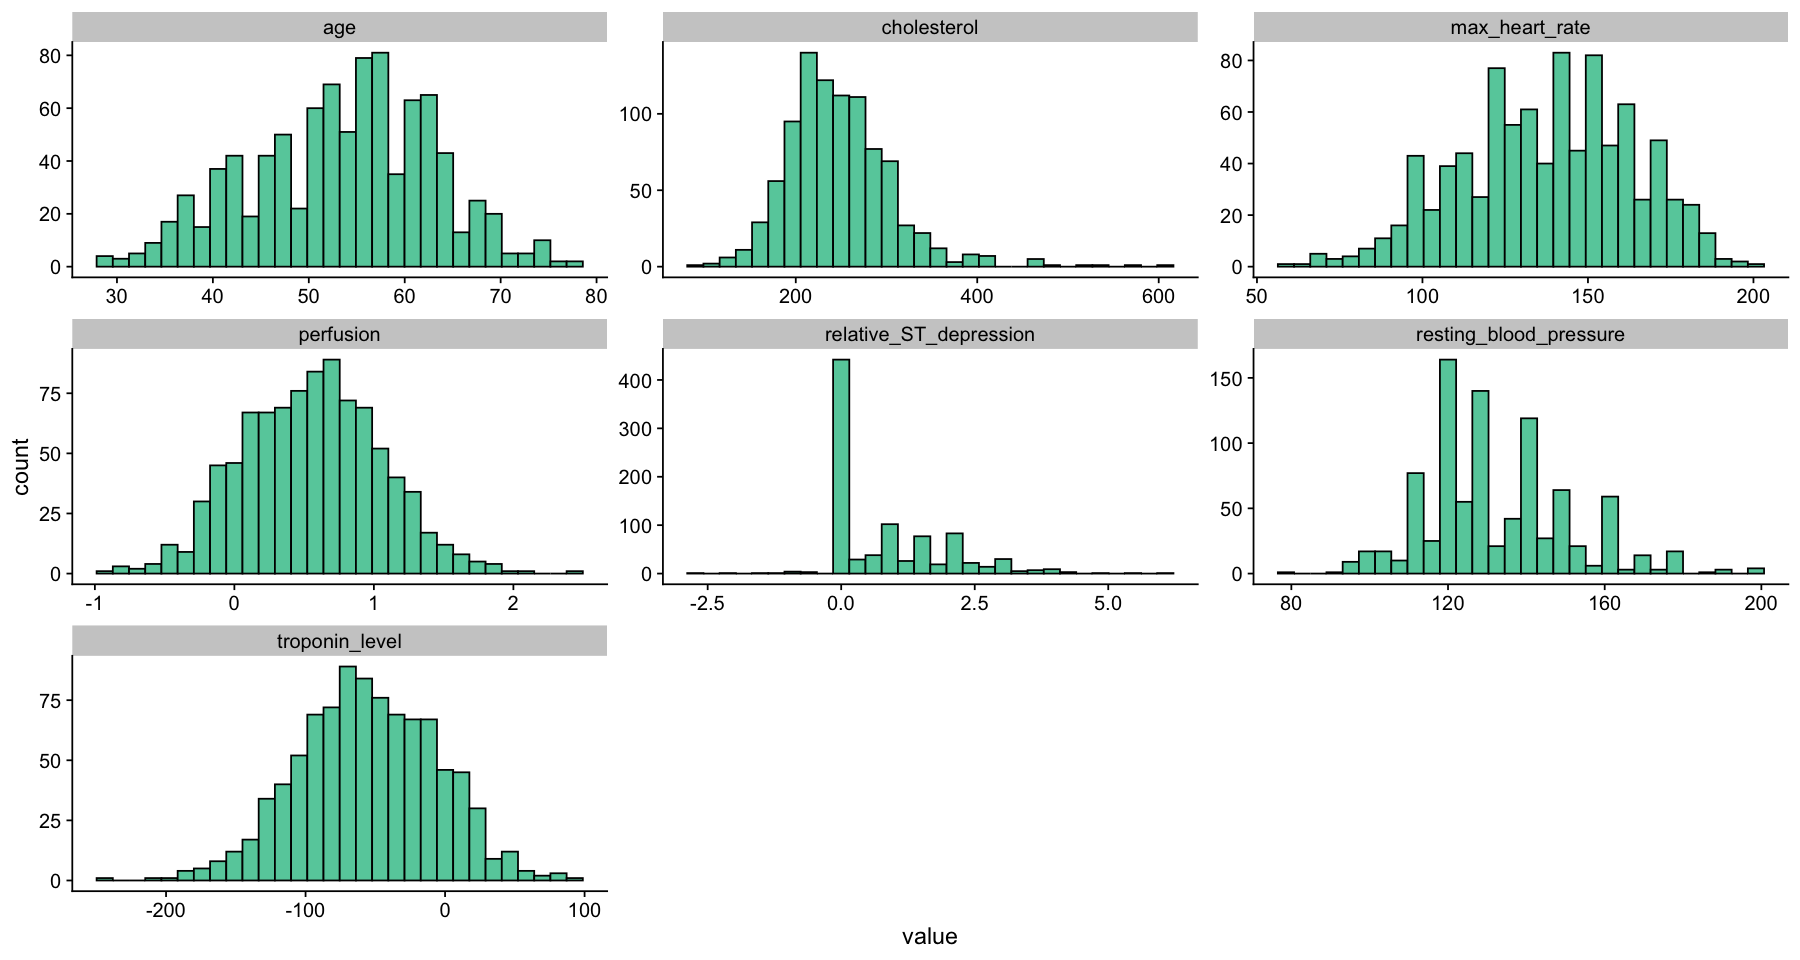

In [123]:
colSums(is.na(heart))

heart_cont <- heart %>% select(age, resting_blood_pressure, cholesterol, max_heart_rate, relative_ST_depression, 
                               perfusion, troponin_level)

heart_cont %>% gather(attribute, value, 1:ncol(heart_cont)) %>%
  ggplot(aes(x = value)) + 
  geom_histogram(fill = "aquamarine3", color = "black", bins = 30) +
  facet_wrap(~attribute, scales = 'free') +
  theme_cowplot()